In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

In [2]:
# mnist dataset (60000 train, 10000 test)
# raw dataset
train_data = pd.read_csv("mnist_train.csv")
test_data = pd.read_csv("mnist_test (2).csv")

#X_train = train_data.drop(["label"], axis = 1).values
#X_test = test_data.drop(["label"], axis = 1).values

y_train = train_data.label.values
y_test = test_data.label.values

# pca (196 features)
rbm_train = pd.read_csv('x_train_rbm.csv')
rbm_test = pd.read_csv('x_test_rbm.csv')


X_train = rbm_train.values
X_test = rbm_test.values


print("X Train Shape :", X_train.shape)
print("X Test Shape ", X_test.shape)
print("y Train Shape :",y_train.shape)
print("y Test Shape ",y_test.shape)

X Train Shape : (60000, 196)
X Test Shape  (10000, 196)
y Train Shape : (60000,)
y Test Shape  (10000,)


In [3]:
X_train = X_train.reshape((-1,14,14))
X_test = X_test.reshape((-1,4,14))

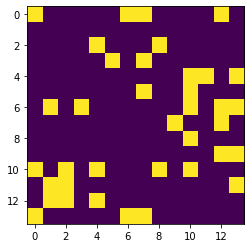

In [4]:
plt.imshow(X_train[1].reshape(14,14))
plt.show()

In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses, Model

In [6]:
X_train = tf.pad(X_train, [[0, 0], [2,2], [2,2]])/255
X_test = tf.pad(X_test, [[0, 0], [2,2], [2,2]])/255
X_train = tf.expand_dims(X_train, axis=3, name=None)
X_test = tf.expand_dims(X_test, axis=3, name=None)
X_train = tf.repeat(X_train, 3, axis=3)
X_test = tf.repeat(X_test, 3, axis=3)
X_val = X_train[-2000:,:,:,:]
y_val = y_train[-2000:]
X_train = X_train[:-2000,:,:,:]
y_train = y_train[:-2000]

In [7]:
X_train.shape

TensorShape([58000, 18, 18, 3])

In [8]:
def inception(x,
              filters_1x1,
              filters_3x3_reduce,
              filters_3x3,
              filters_5x5_reduce,
              filters_5x5,
              filters_pool):
    path1 = layers.Conv2D(filters_1x1, (1, 1), padding='same',    activation='relu')(x)
    path2 = layers.Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(x)
    path2 = layers.Conv2D(filters_3x3, (1, 1), padding='same', activation='relu')(path2)
    path3 = layers.Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(x)
    path3 = layers.Conv2D(filters_5x5, (1, 1), padding='same', activation='relu')(path3)
    path4 = layers.MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    path4 = layers.Conv2D(filters_pool, (1, 1), padding='same', activation='relu')(path4)
    return tf.concat([path1, path2, path3, path4], axis=3)

In [9]:
inp = layers.Input(shape=(18, 18, 3))
input_tensor = layers.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear", input_shape=X_train.shape[1:])(inp)
x = layers.Conv2D(64, 7, strides=2, padding='same', activation='relu')(input_tensor)
x = layers.MaxPooling2D(3, strides=2)(x)
x = layers.Conv2D(64, 1, strides=1, padding='same', activation='relu')(x)
x = layers.Conv2D(192, 3, strides=1, padding='same', activation='relu')(x)
x = layers.MaxPooling2D(3, strides=2)(x)
x = inception(x, filters_1x1=64, filters_3x3_reduce=96, filters_3x3=128, filters_5x5_reduce=16, filters_5x5=32, filters_pool=32)
x = inception(x, filters_1x1=128, filters_3x3_reduce=128, filters_3x3=192, filters_5x5_reduce=32, filters_5x5=96, filters_pool=64)
x = layers.MaxPooling2D(3, strides=2)(x)
x = inception(x, filters_1x1=192, filters_3x3_reduce=96, filters_3x3=208, filters_5x5_reduce=16, filters_5x5=48, filters_pool=64)
aux1 = layers.AveragePooling2D((5, 5), strides=3)(x)
aux1 =layers.Conv2D(128, 1, padding='same', activation='relu')(aux1)
aux1 = layers.Flatten()(aux1)
aux1 = layers.Dense(1024, activation='relu')(aux1)
aux1 = layers.Dropout(0.7)(aux1)
aux1 = layers.Dense(10, activation='softmax')(aux1)
x = inception(x, filters_1x1=160, filters_3x3_reduce=112, filters_3x3=224, filters_5x5_reduce=24, filters_5x5=64, filters_pool=64)
x = inception(x, filters_1x1=128, filters_3x3_reduce=128, filters_3x3=256, filters_5x5_reduce=24, filters_5x5=64, filters_pool=64)
x = inception(x, filters_1x1=112, filters_3x3_reduce=144, filters_3x3=288, filters_5x5_reduce=32, filters_5x5=64, filters_pool=64)
aux2 = layers.AveragePooling2D((5, 5), strides=3)(x)
aux2 =layers.Conv2D(128, 1, padding='same', activation='relu')(aux2)
aux2 = layers.Flatten()(aux2)
aux2 = layers.Dense(1024, activation='relu')(aux2)
aux2 = layers.Dropout(0.7)(aux2) 
aux2 = layers.Dense(10, activation='softmax')(aux2)
x = inception(x, filters_1x1=256, filters_3x3_reduce=160, filters_3x3=320, filters_5x5_reduce=32, filters_5x5=128, filters_pool=128)
x = layers.MaxPooling2D(3, strides=2)(x)
x = inception(x, filters_1x1=256, filters_3x3_reduce=160, filters_3x3=320, filters_5x5_reduce=32, filters_5x5=128, filters_pool=128)
x = inception(x, filters_1x1=384, filters_3x3_reduce=192, filters_3x3=384, filters_5x5_reduce=48, filters_5x5=128, filters_pool=128)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
out = layers.Dense(10, activation='softmax')(x)

In [10]:
model = Model(inputs = inp, outputs = [out, aux1, aux2])

In [11]:
model.compile(optimizer='adam', 
              loss=[losses.sparse_categorical_crossentropy,
                    losses.sparse_categorical_crossentropy,
                    losses.sparse_categorical_crossentropy]
              ,loss_weights=[1, 0.3, 0.3],
              metrics=['accuracy'])
history = model.fit(X_train, [y_train, y_train, y_train], validation_data=(X_val, [y_val, y_val, y_val]), batch_size=64, epochs=10)

Epoch 1/10
907/907 [==============================] - 2262s 2s/step - loss: 3.6832 - dense_4_loss: 2.3020 - dense_1_loss: 2.3020 - dense_3_loss: 2.3021 - dense_4_accuracy: 0.1104 - dense_1_accuracy: 0.1086 - dense_3_accuracy: 0.1091 - val_loss: 3.6831 - val_dense_4_loss: 2.3020 - val_dense_1_loss: 2.3020 - val_dense_3_loss: 2.3019 - val_dense_4_accuracy: 0.1070 - val_dense_1_accuracy: 0.1070 - val_dense_3_accuracy: 0.1070
Epoch 2/10
907/907 [==============================] - 2255s 2s/step - loss: 3.6822 - dense_4_loss: 2.3013 - dense_1_loss: 2.3015 - dense_3_loss: 2.3014 - dense_4_accuracy: 0.1140 - dense_1_accuracy: 0.1139 - dense_3_accuracy: 0.1140 - val_loss: 3.6830 - val_dense_4_loss: 2.3019 - val_dense_1_loss: 2.3019 - val_dense_3_loss: 2.3018 - val_dense_4_accuracy: 0.1070 - val_dense_1_accuracy: 0.1070 - val_dense_3_accuracy: 0.1070
Epoch 3/10
907/907 [==============================] - 2256s 2s/step - loss: 3.6820 - dense_4_loss: 2.3012 - dense_1_loss: 2.3013 - dense_3_loss: 2.3